In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

In [2]:
device = ('cuda' if torch.cuda.is_available()
         else 'mps' if torch.backends.mps.is_available()
         else 'cpu')
print(f'Using {device} device')

Using cuda device


In [3]:
def plot_results(train_losses, train_accs, test_losses, test_accs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label='Train')
    axes[0].plot(xs, test_losses, label='Test')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label='Train')
    axes[1].plot(xs, test_accs, label='Test')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [4]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    running_loss, correct = 0, 0
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device = device):
    running_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            running_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader, test_loader, device = device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for epoch in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        test_loss, test_acc = test_step(model, criterion, test_loader, device)
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Test Loss = {test_loss:.3f} | Test Acc = {test_acc:.2f}%')
        train_losses.append(train_loss), train_accs.append(train_acc), test_losses.append(test_loss), test_accs.append(test_acc)
    plot_results(train_losses, train_accs, test_losses, test_accs)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'test_loss': test_losses, 'test_acc': test_accs}

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5, ))])

train_dataset = EMNIST(root = './data', split = 'balanced', train = True, download = True, transform = transform)
test_dataset = EMNIST(root = './data', split = 'balanced', train = False, download = True, transform = transform)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

classes = train_dataset.classes
print(f'Classes:\n{classes}')

100%|██████████| 562M/562M [00:22<00:00, 24.5MB/s] 


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Train dataset size: 112800
Test dataset size: 18800
Classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [6]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 64, shuffle = True)

for x, y in test_loader:
    print(f'Shape of X [N, C, H, W]: {x.shape}')
    print(f'Shape of y: {y.shape}{y.dtype}')
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64])torch.int64


In [7]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 128),
                                    nn.ReLU(), nn.Linear(128, 128),
                                    nn.ReLU(), nn.Linear(128, 64),
                                    nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 1.176 | Train Acc = 66.27% | Test Loss = 1.190 | Test Acc = 65.64%: 100%|██████████| 30/30 [13:07<00:00, 26.24s/it]


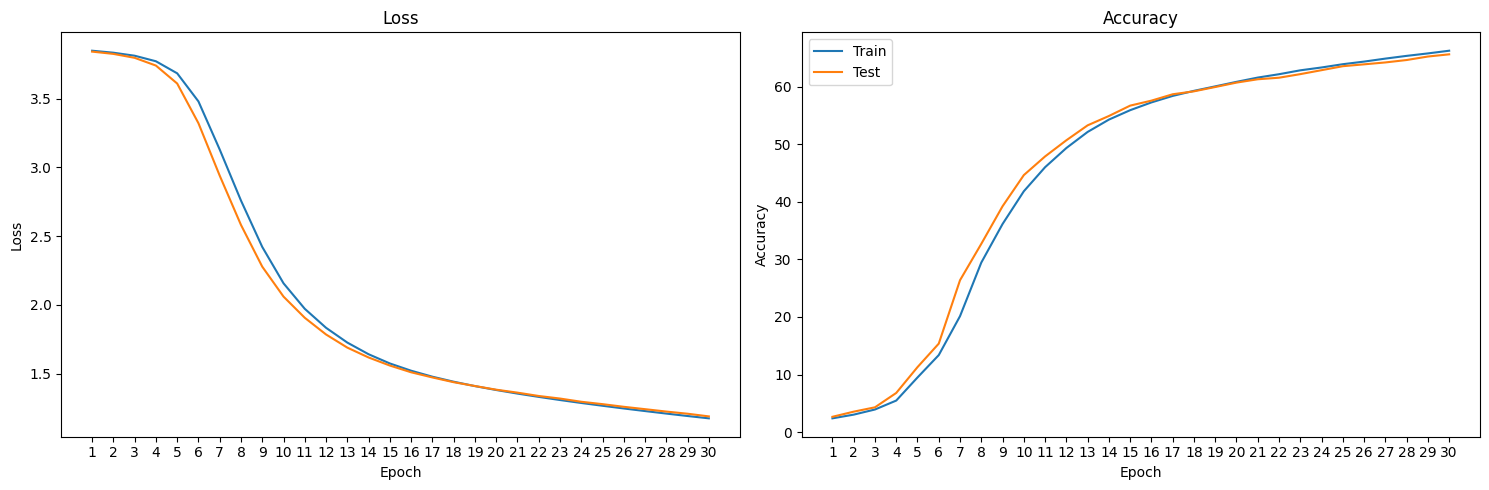

In [8]:
model = SimpleNN(input_size = 28*28, num_classes = len(classes)).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001)
results = train_model(model, 30, optimizer, train_loader, test_loader)

Train Loss = 0.356 | Train Acc = 86.78% | Test Loss = 0.576 | Test Acc = 82.74%: 100%|██████████| 20/20 [09:01<00:00, 27.06s/it]


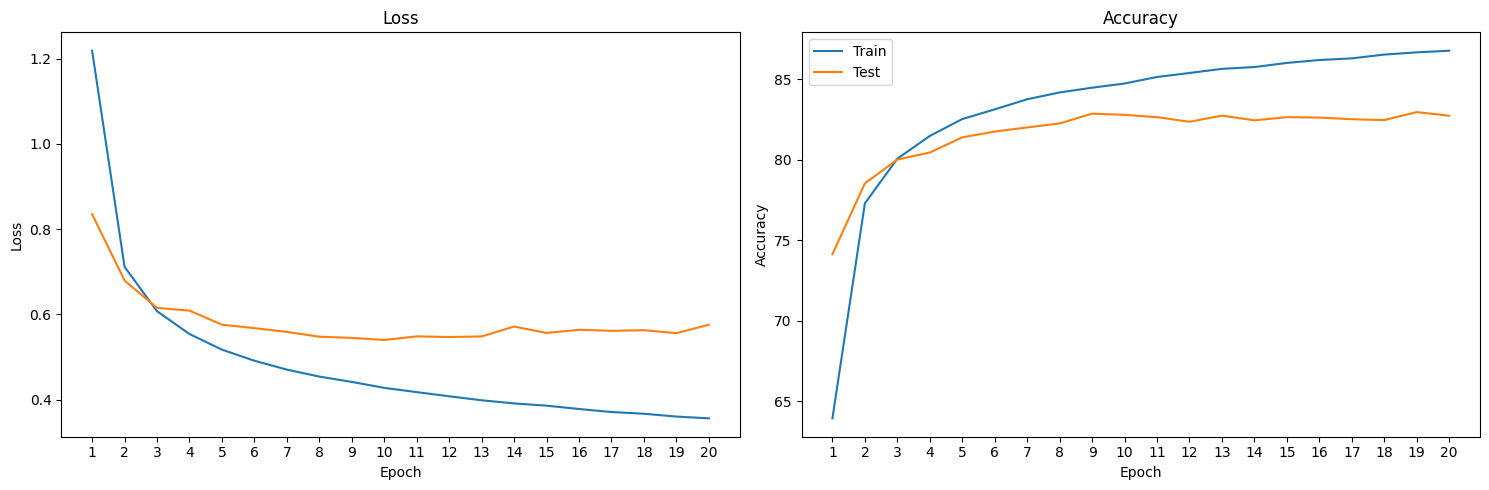

In [9]:
model = SimpleNN(input_size = 28*28, num_classes = len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, test_loader)

In [10]:
class BiggerNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 512),
                                    nn.ReLU(), nn.Linear(512, 512),
                                    nn.ReLU(), nn.Linear(512, 512),
                                    nn.ReLU(), nn.Linear(512, 256),
                                    nn.ReLU(), nn.Linear(256, 256),
                                    nn.ReLU(), nn.Linear(256, 256),
                                    nn.ReLU(), nn.Linear(256, 128),
                                    nn.ReLU(), nn.Linear(128, 128),
                                    nn.ReLU(), nn.Linear(128, 128),
                                    nn.ReLU(), nn.Linear(128, 64),
                                    nn.ReLU(), nn.Linear(64, 64),
                                    nn.ReLU(), nn.Linear(64, 64),
                                    nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.503 | Train Acc = 84.23% | Test Loss = 0.621 | Test Acc = 81.84%: 100%|██████████| 20/20 [09:57<00:00, 29.87s/it]


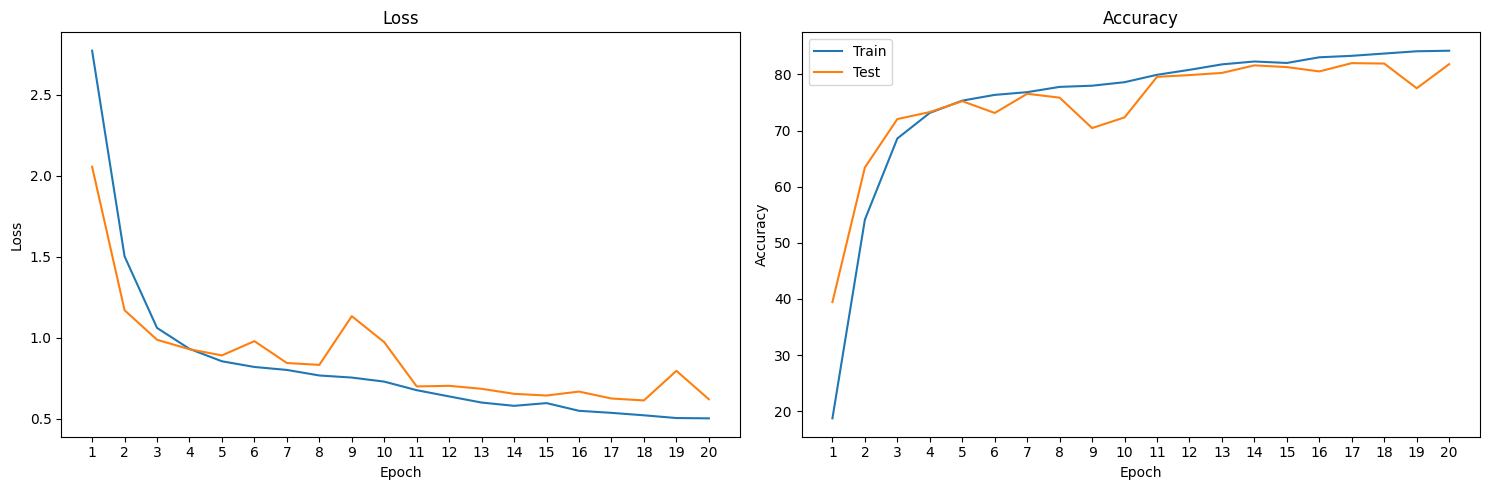

In [11]:
model = BiggerNN(input_size = 28*28, num_classes = len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, test_loader)

In [12]:
class BiggerBN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerBN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
                                    nn.ReLU(), nn.Linear(512, 512), nn.BatchNorm1d(512),
                                    nn.ReLU(), nn.Linear(512, 512), nn.BatchNorm1d(512),
                                    nn.ReLU(), nn.Linear(512, 256), nn.BatchNorm1d(256),
                                    nn.ReLU(), nn.Linear(256, 256), nn.BatchNorm1d(256),
                                    nn.ReLU(), nn.Linear(256, 256), nn.BatchNorm1d(256),
                                    nn.ReLU(), nn.Linear(256, 128), nn.BatchNorm1d(128),
                                    nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                    nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                    nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                    nn.ReLU(), nn.Linear(128, 64), nn.BatchNorm1d(64),
                                    nn.ReLU(), nn.Linear(64, 64), nn.BatchNorm1d(64),
                                    nn.ReLU(), nn.Linear(64, 64), nn.BatchNorm1d(64),
                                    nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.271 | Train Acc = 89.88% | Test Loss = 0.418 | Test Acc = 86.61%: 100%|██████████| 20/20 [11:10<00:00, 33.54s/it]


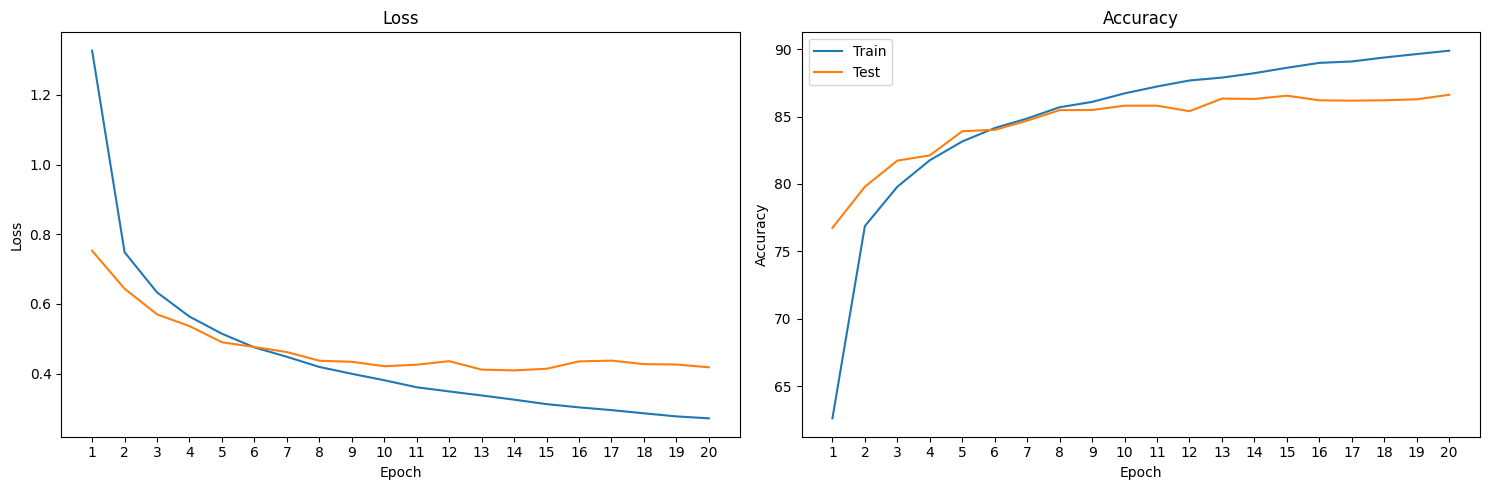

In [13]:
model = BiggerBN(input_size = 28*28, num_classes = len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, test_loader)

In [15]:
class BiggerDO(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerDO, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.477 | Train Acc = 84.49% | Test Loss = 0.424 | Test Acc = 86.03%: 100%|██████████| 20/20 [11:34<00:00, 34.71s/it]


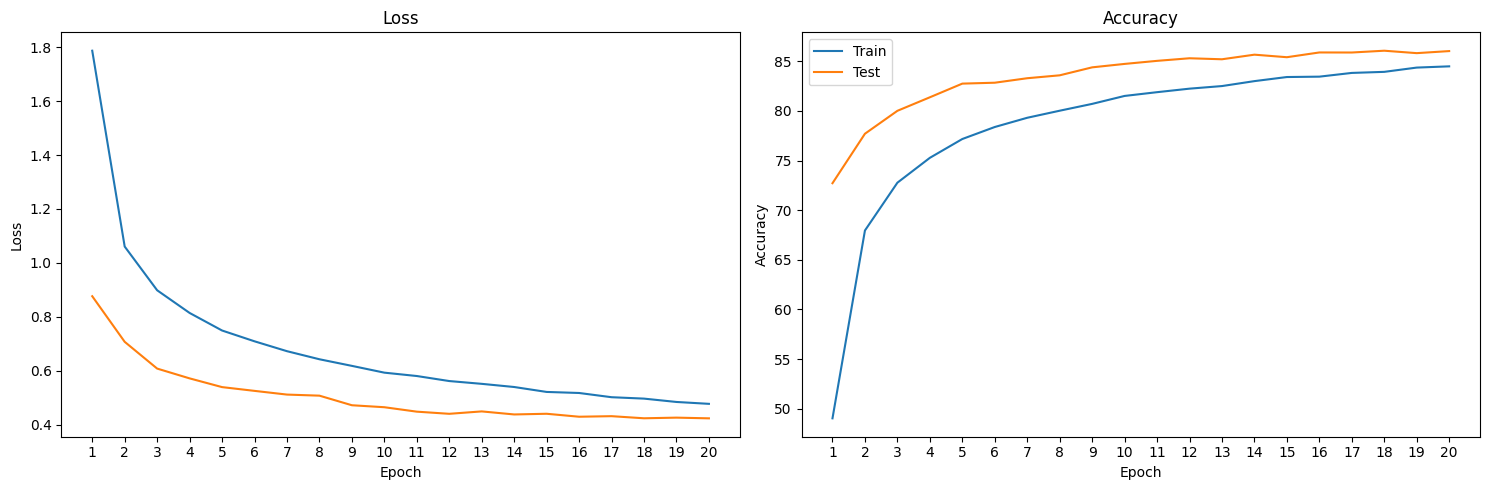

In [16]:
model = BiggerDO(input_size = 28*28, num_classes = len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, test_loader)

Train Loss = 0.376 | Train Acc = 87.19% | Test Loss = 0.384 | Test Acc = 87.24%: 100%|██████████| 10/10 [05:48<00:00, 34.87s/it]


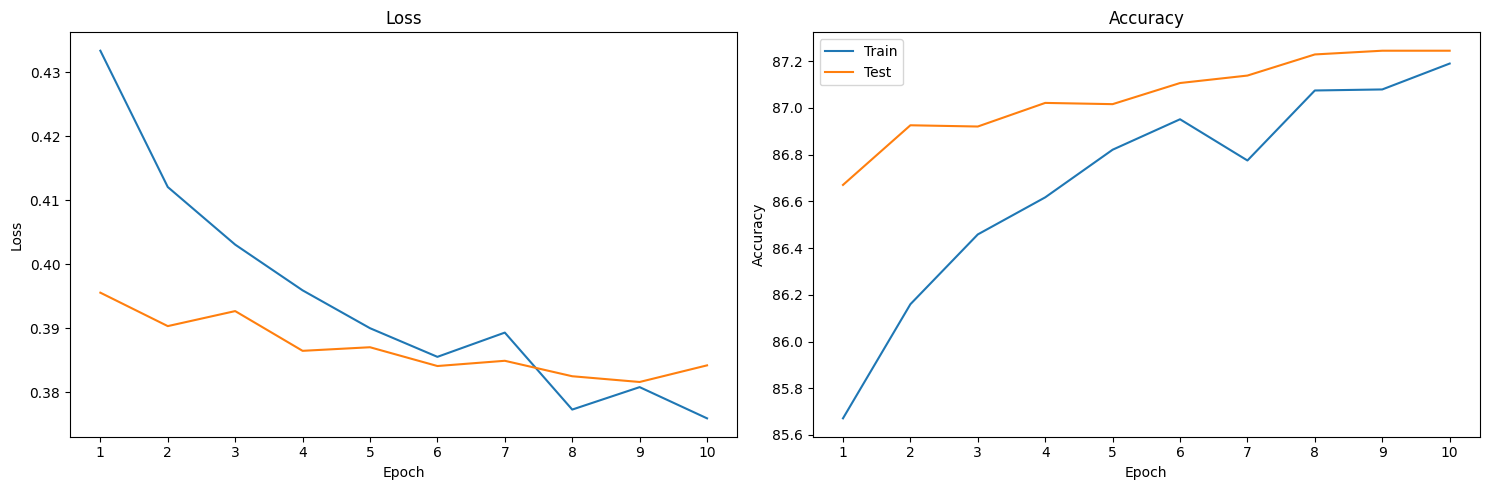

In [17]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
results = train_model(model, 10, optimizer, train_loader, test_loader)